### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from ml_utils import load_data


service_account_path = '/home/yusuf/DataScience/dream_games/ybektas20.json'
df = load_data(service_account_path)
df.info()


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342519 entries, 0 to 342518
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            342519 non-null  object 
 1   country            342519 non-null  object 
 2   age                342519 non-null  Int64  
 3   platform           342519 non-null  object 
 4   network            342519 non-null  object 
 5   time_spend         342519 non-null  Int64  
 6   coin_spend         342519 non-null  Int64  
 7   coin_earn          342519 non-null  Int64  
 8   level_success      342519 non-null  Int64  
 9   level_fail         342519 non-null  Int64  
 10  level_start        342519 non-null  Int64  
 11  booster_spend      342519 non-null  Int64  
 12  booster_earn       342519 non-null  Int64  
 13  coin_amount        342519 non-null  Int64  
 14  event_participate  342519 non-null  Int64  
 15  shop_open          342519 non-null  float64
 16  d3

In [2]:
from ml_utils import get_X_y
X, y = get_X_y(df)
print(X.shape, y.shape)

categorical_columns = ['country', 'platform', 'network']
one_hot_encoded_columns = ['event_participate']

for col in categorical_columns:
    X = pd.get_dummies(X, columns=[col], prefix=col)
    one_hot_encoded_columns += [c for c in X.columns if c.startswith(col+'_')] 
X.columns

(342519, 20) (342519,)


/home/yusuf/DataScience/dream_games/q3/ml_utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['time_spend_rate'] = df['time_spend'] / (df['level_start']+1)
/home/yusuf/DataScience/dream_games/q3/ml_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['success_rate'] = df['level_success'] / (df['level_start'] + 1)
/home/yusuf/DataScience/dream_games/q3/ml_utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Index(['age', 'time_spend', 'level_success', 'event_participate',
       'coin_amount', 'booster_spend', 'shop_open', 'time_spend_rate',
       'success_rate', 'net_coin', 'net_booster', 'net_coin_rate',
       'net_booster_freq', 'booster_spend_ratio', 'coin_spend_ratio',
       'shop_open_frequency', 'event_participate_frequency',
       'country_Amaryllis', 'country_Azurelia', 'country_Brighthaven',
       'country_Crystalbrook', 'country_Eldoria', 'country_Emberlyn',
       'country_Floravia', 'country_Frostford', 'country_Gleamwood',
       'country_Glimmerdell', 'country_Luminara', 'country_Moonvale',
       'country_Rosewyn', 'country_Seraphina', 'country_Silvermist',
       'country_Starcliff', 'country_Sunridge', 'country_Thalassia',
       'country_Windemere', 'country_Zephyra', 'platform_android',
       'platform_ios', 'network_Bird', 'network_Box', 'network_Cupboard',
       'network_Curtain', 'network_Dynamite', 'network_Egg', 'network_Grass',
       'network_Honey', 'net

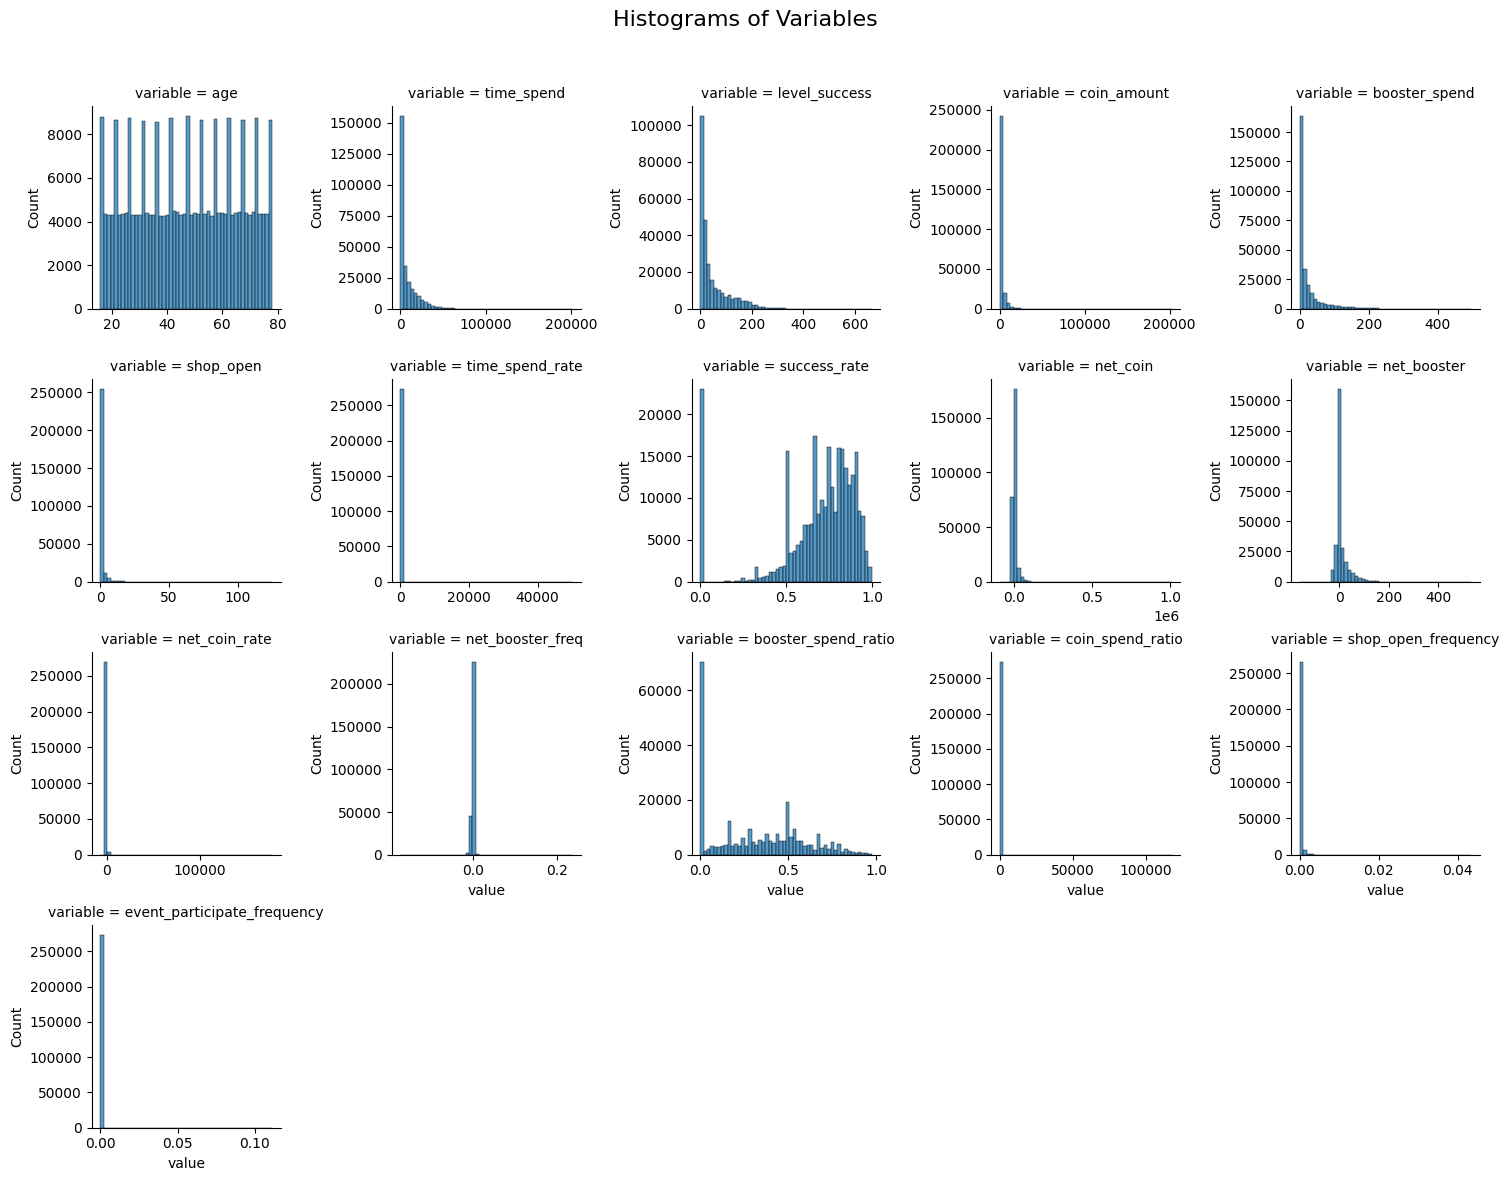

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from ml_utils import plot_histograms
#X_train.drop(columns=one_hot_encoded_columns).hist(figsize=(20,20), bins=50)
plot_histograms(X_train.drop(columns=one_hot_encoded_columns))

### Design Matrix Transformation

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

"""
Comparing different transformers to decide which one to use
"""

scalers = {
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
    "PowerTransformer": PowerTransformer(),
    "QuantileTransformer": QuantileTransformer(output_distribution="normal")
}

rocauc_scores = {}

for name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('logreg', LogisticRegression(max_iter=1000))
    ])
    
    scores = cross_val_score(pipeline, X_train.drop(columns=one_hot_encoded_columns), y_train, cv=5, scoring="roc_auc")
    rocauc_scores[name] = scores
    print(f"{name}: Mean ROC AUC = {np.mean(scores):.3f} (Std: {np.std(scores):.3f})")

del pipeline, scores, scaler

rocauc_scores

StandardScaler: Mean ROC AUC = 0.791 (Std: 0.003)
RobustScaler: Mean ROC AUC = 0.791 (Std: 0.003)
PowerTransformer: Mean ROC AUC = 0.813 (Std: 0.003)
QuantileTransformer: Mean ROC AUC = 0.805 (Std: 0.002)


{'StandardScaler': array([0.78860411, 0.78826542, 0.7906461 , 0.79351075, 0.79545355]),
 'RobustScaler': array([0.78874898, 0.7881997 , 0.79059849, 0.79343326, 0.79535519]),
 'PowerTransformer': array([0.80827726, 0.81175929, 0.81238632, 0.81528388, 0.81607266]),
 'QuantileTransformer': array([0.80168501, 0.80536395, 0.80547339, 0.80575231, 0.80860884])}

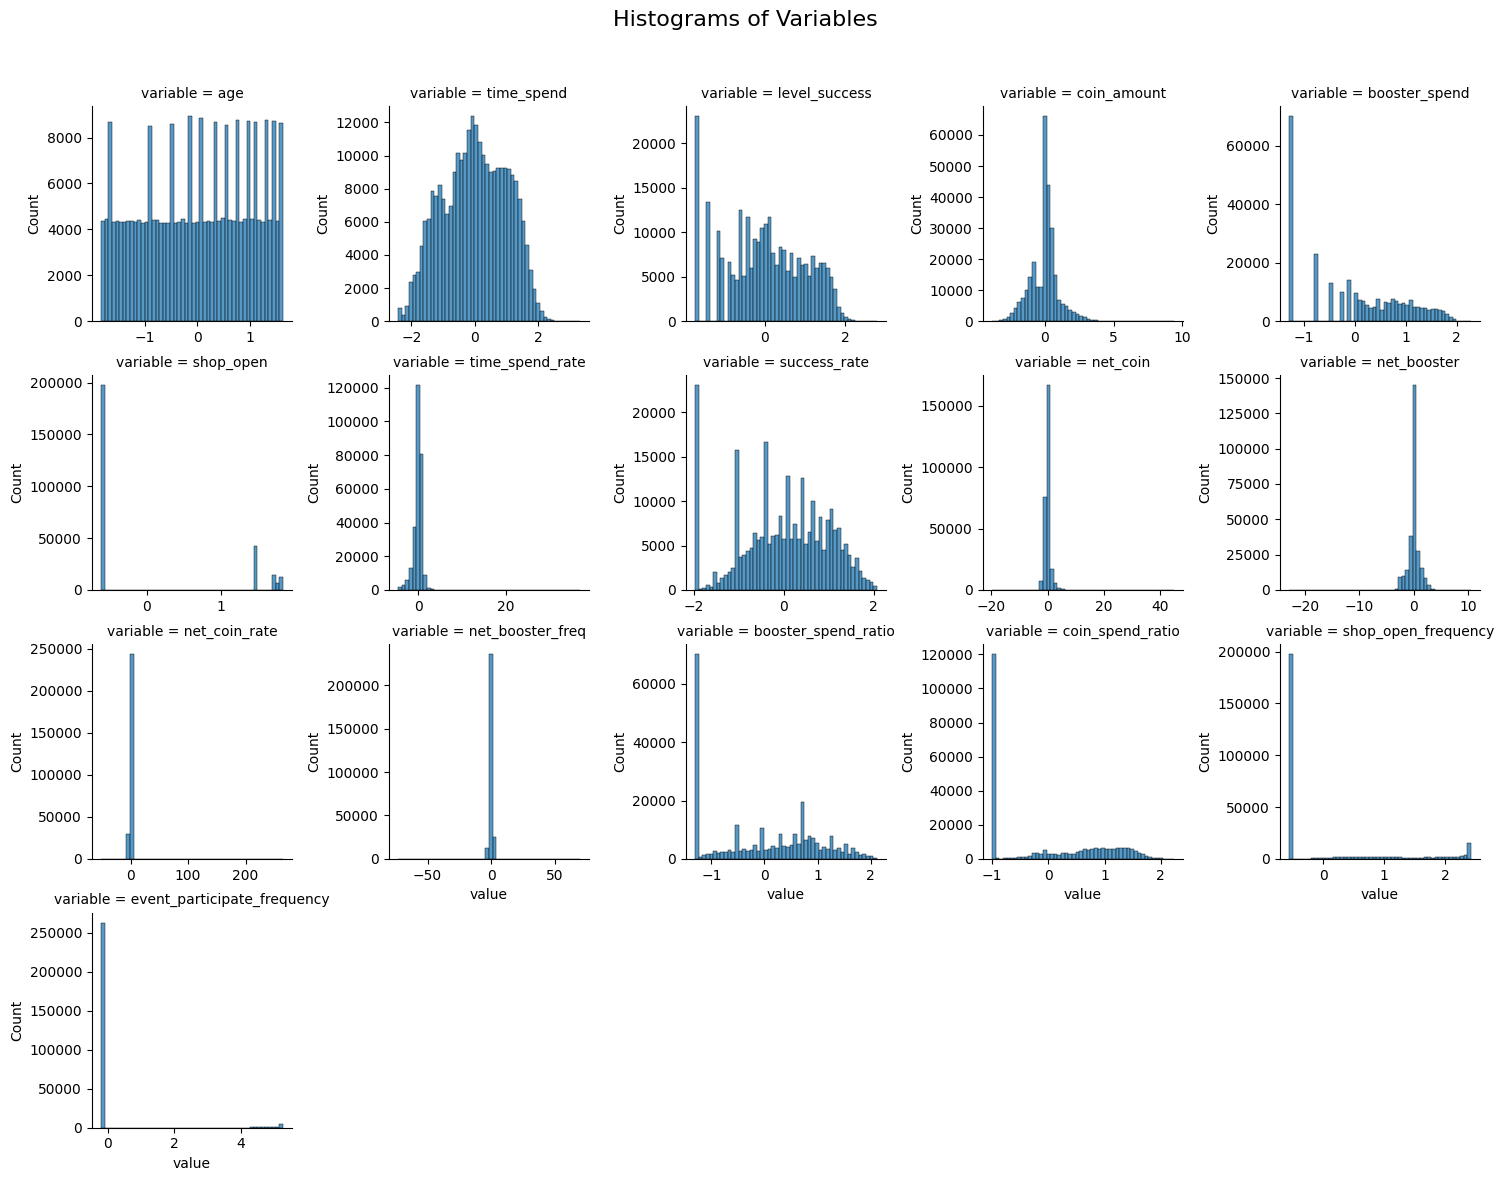

In [5]:
"""
Pt is the best, so we will use it
"""

pt = PowerTransformer()
X_train_scaled = pt.fit_transform(X_train.drop(columns=one_hot_encoded_columns))
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.drop(columns=one_hot_encoded_columns).columns, index=X_train.index)
X_test_scaled = pt.transform(X_test.drop(columns=one_hot_encoded_columns))
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.drop(columns=one_hot_encoded_columns).columns, index=X_test.index)

plot_histograms(X_train_scaled)


### Target and Features Interactions

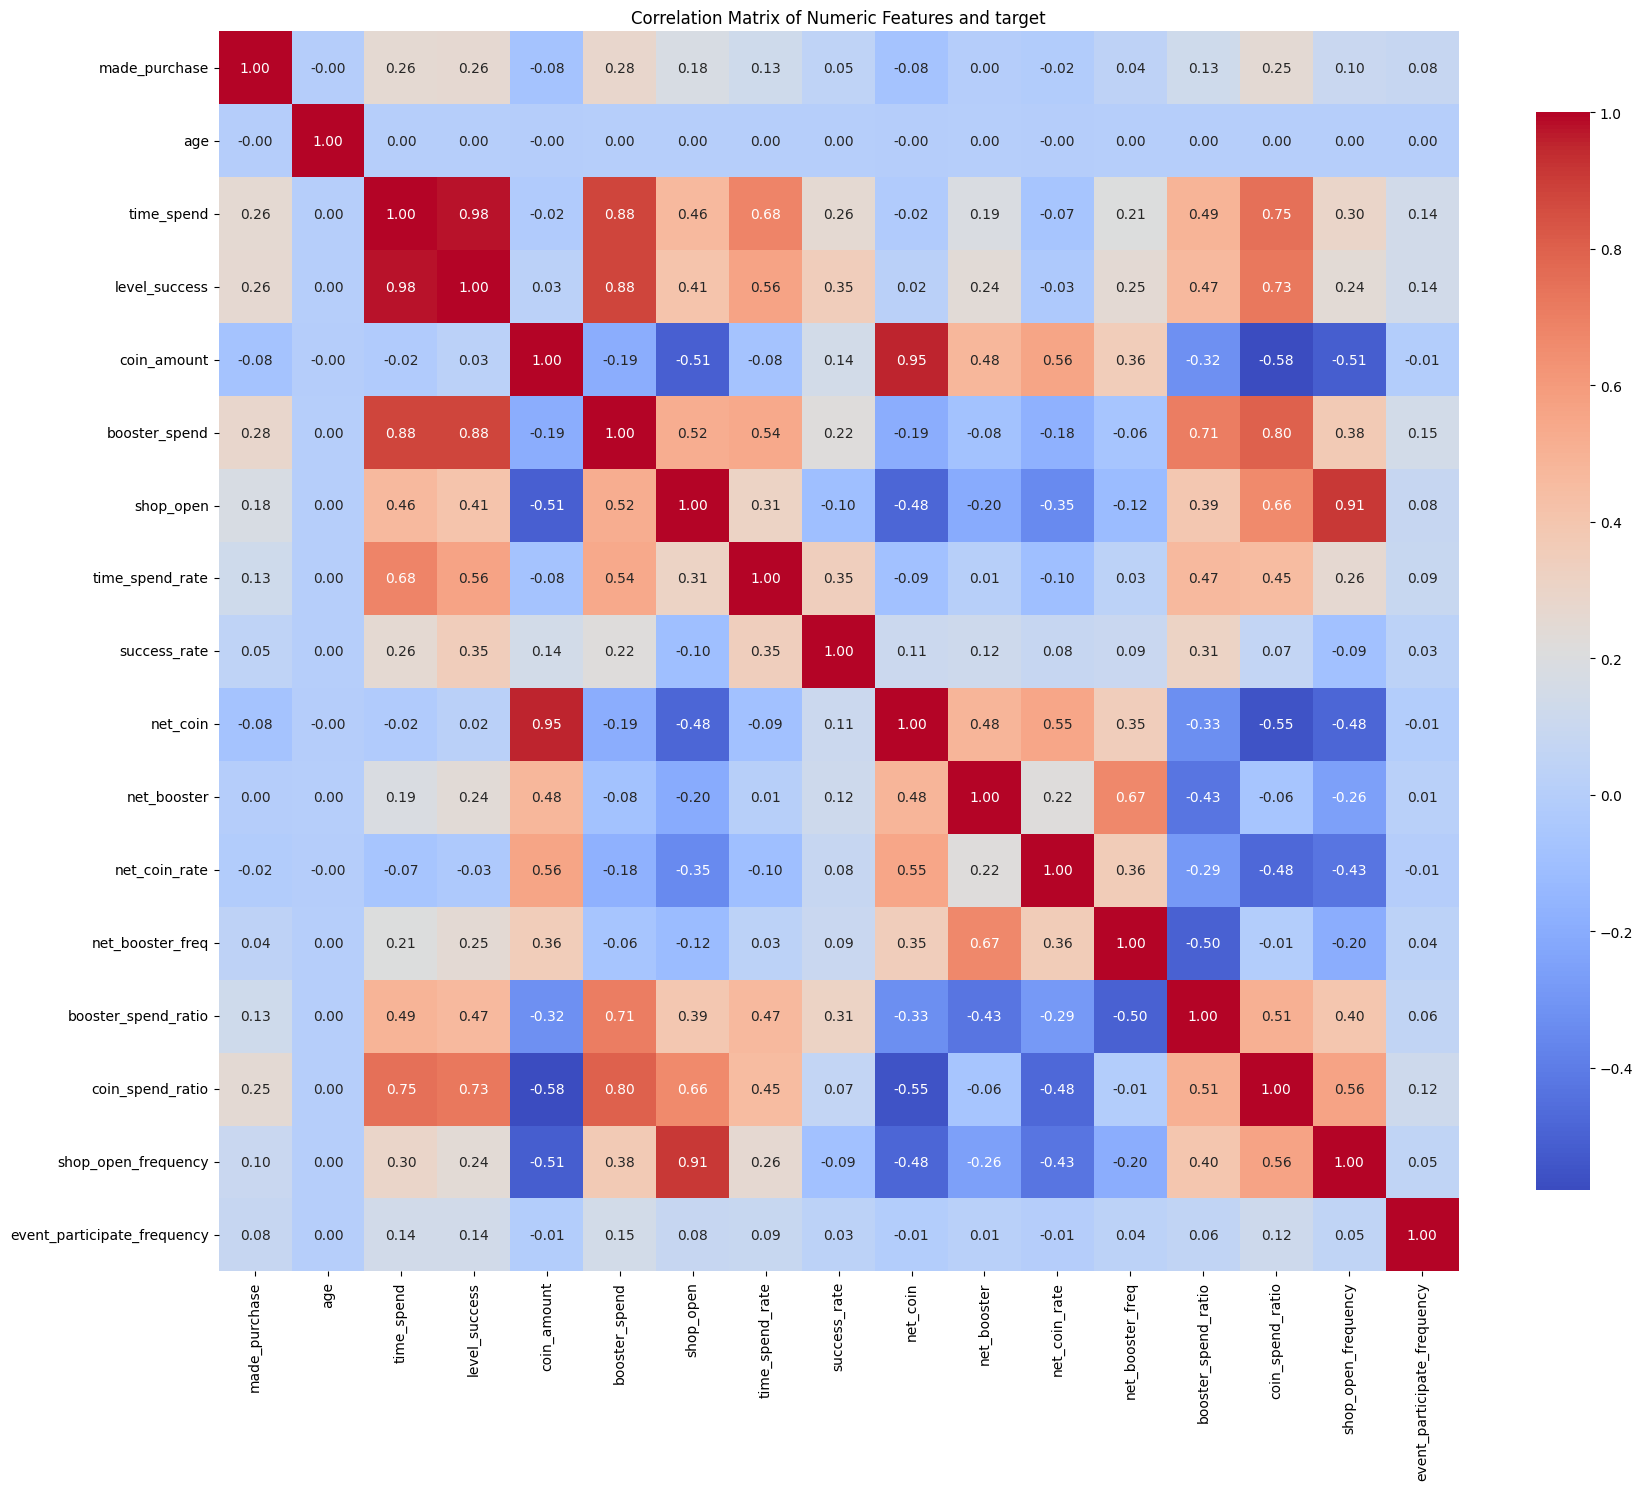

In [6]:
### correlation matrix between features
import seaborn as sns
import matplotlib.pyplot as plt

corr = pd.concat([y_train, X_train_scaled],axis=1).corr()
plt.figure(figsize=(20,20))
plt.title("Correlation Matrix of Numeric Features and target")
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .7})
plt.show()


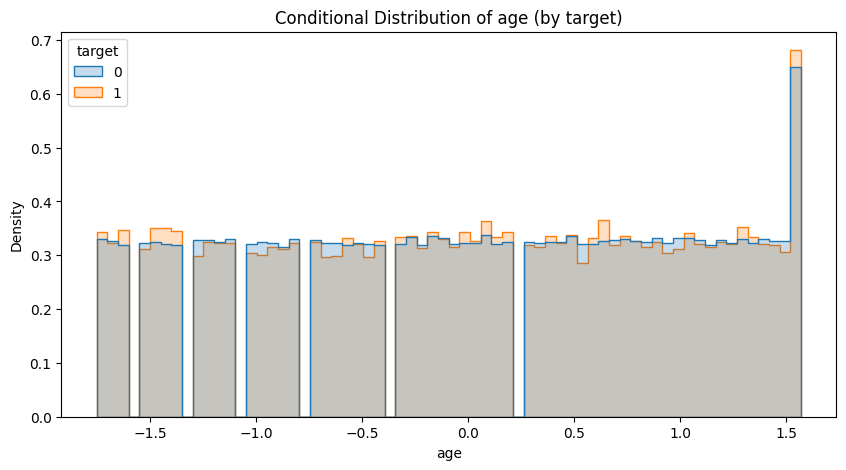

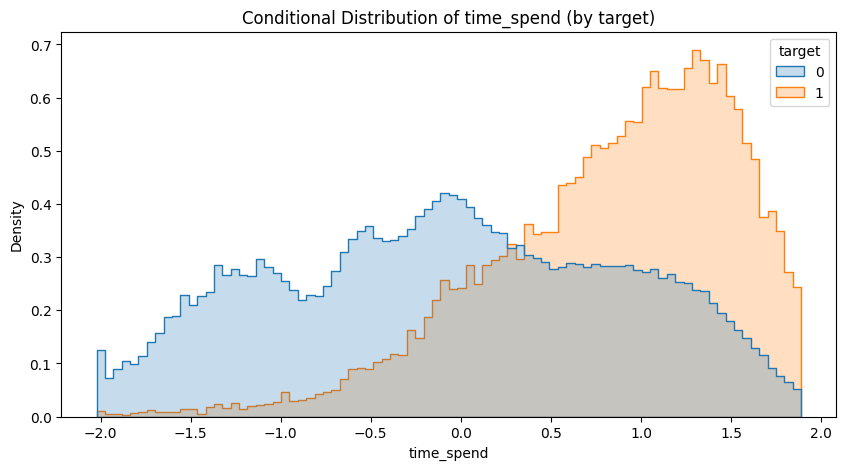

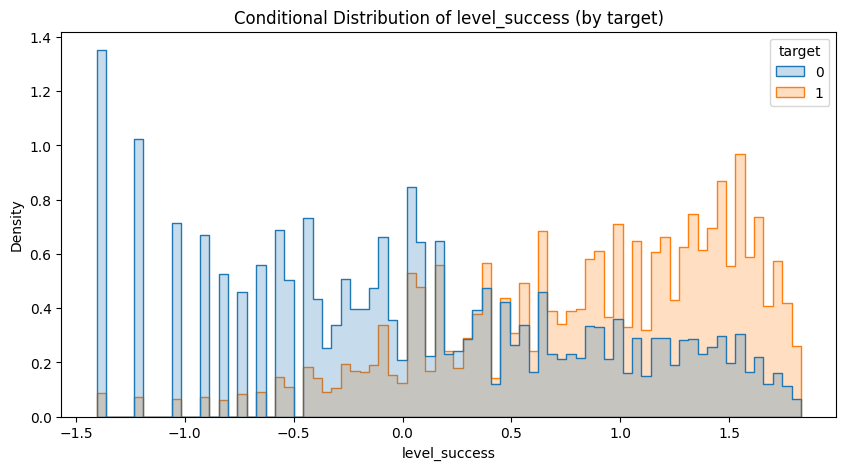

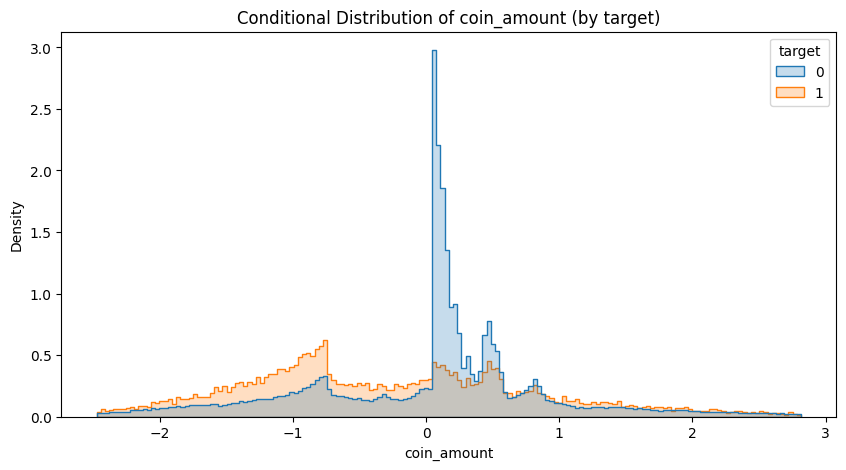

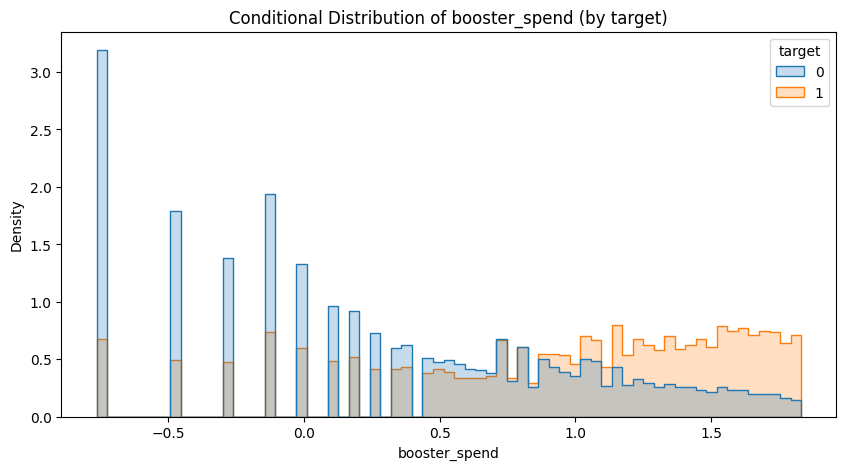

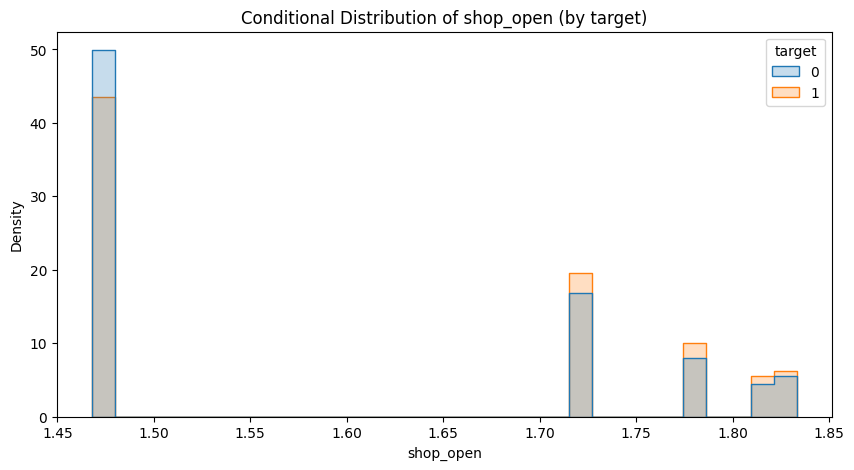

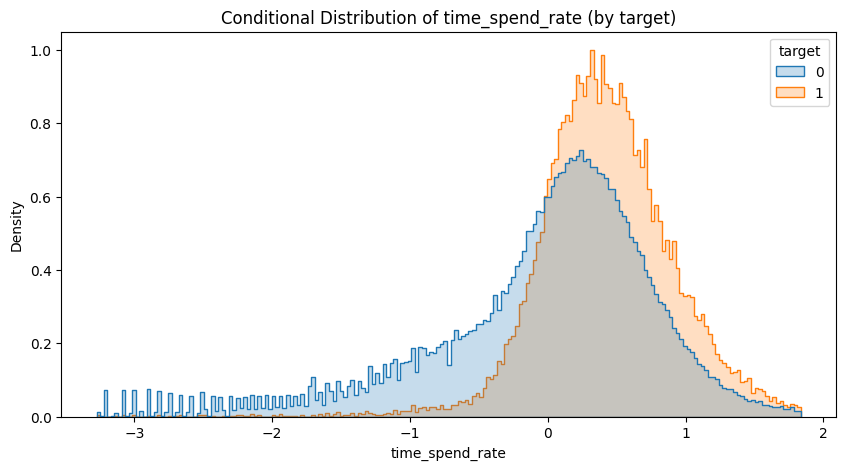

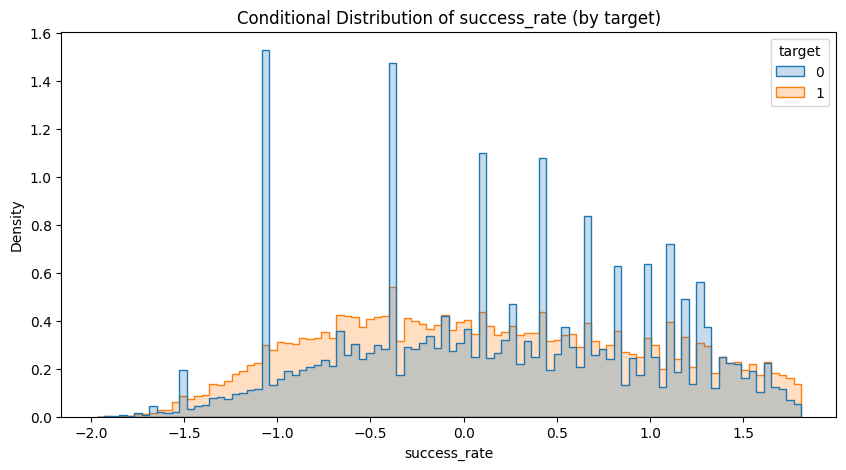

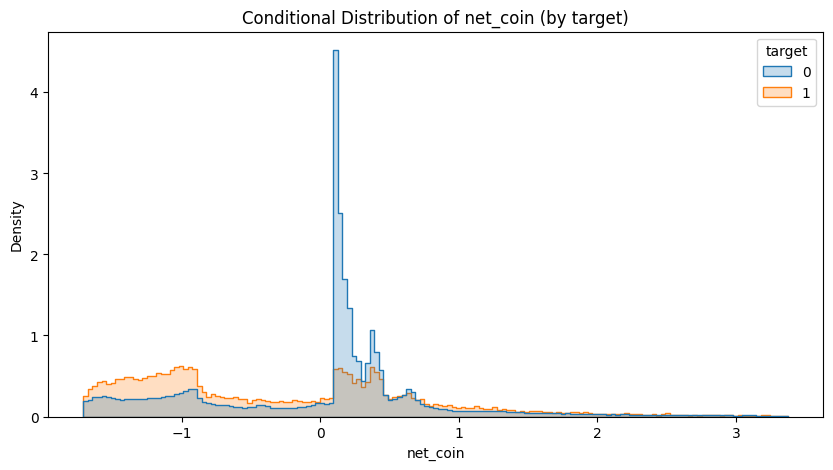

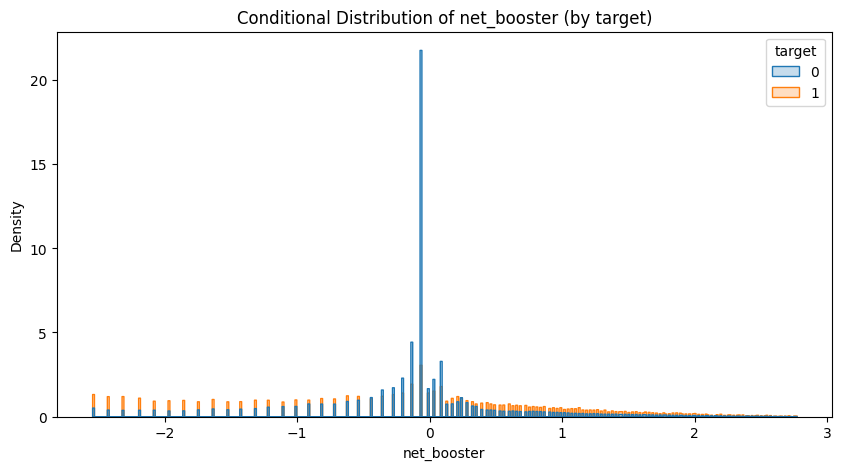

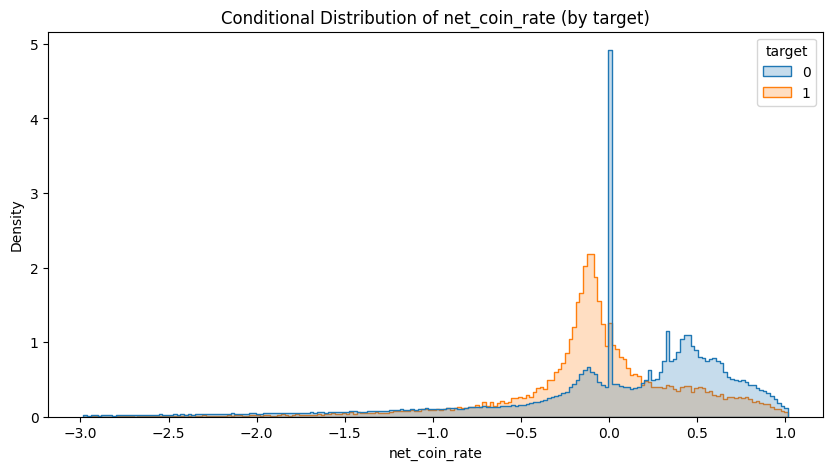

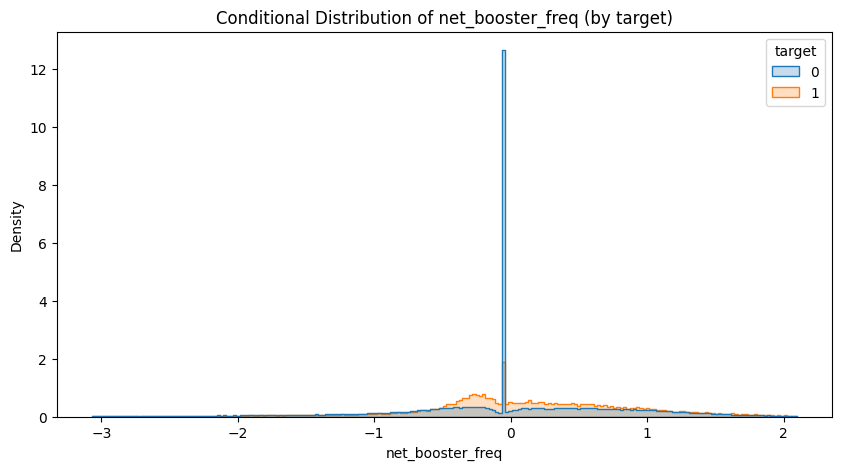

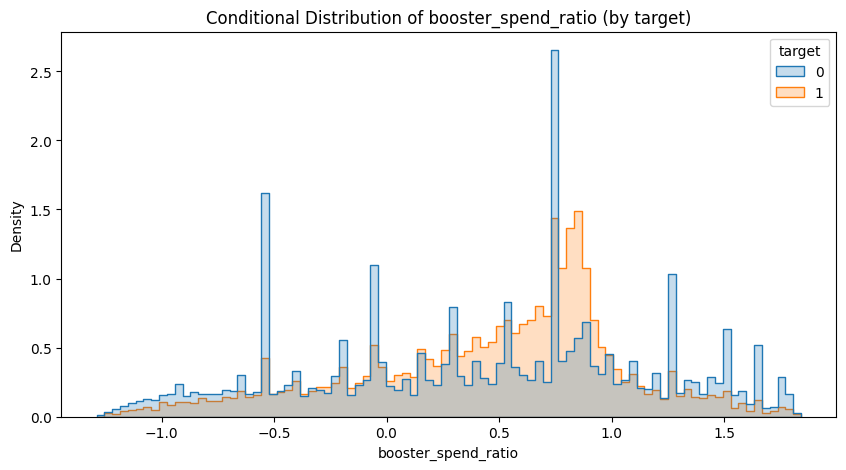

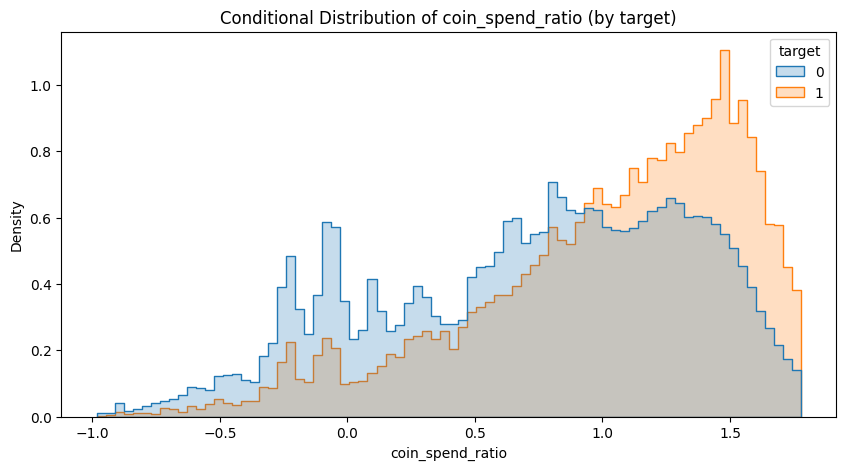

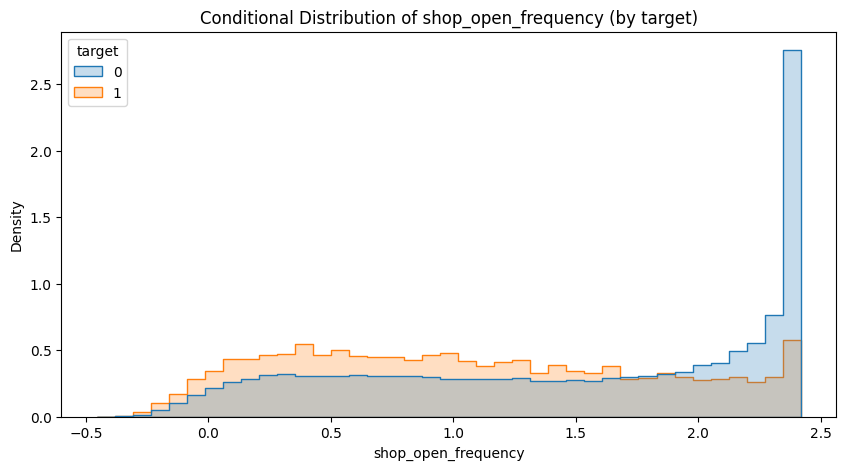

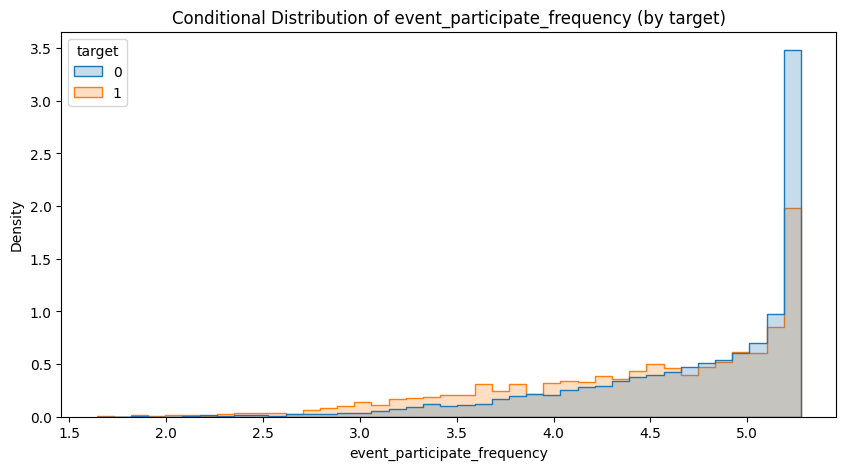

In [7]:
from ml_utils import plot_conditional_distributions
plot_conditional_distributions(X_train_scaled, y_train, min_quantile=0.01)

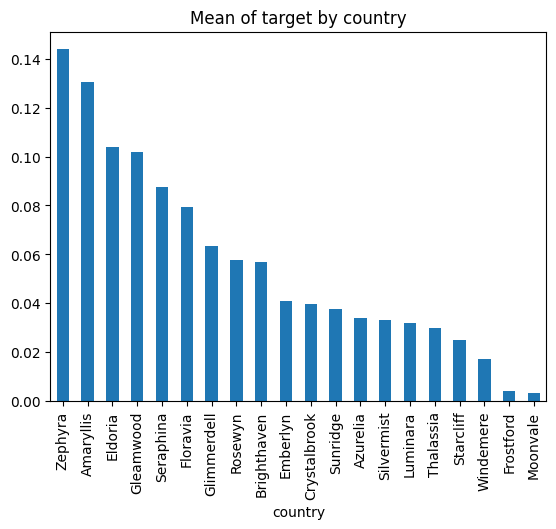

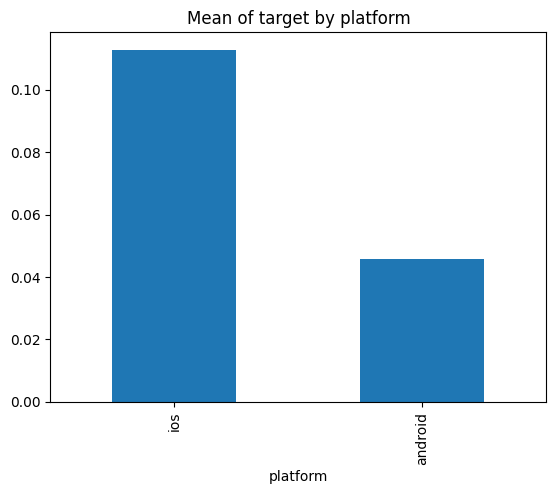

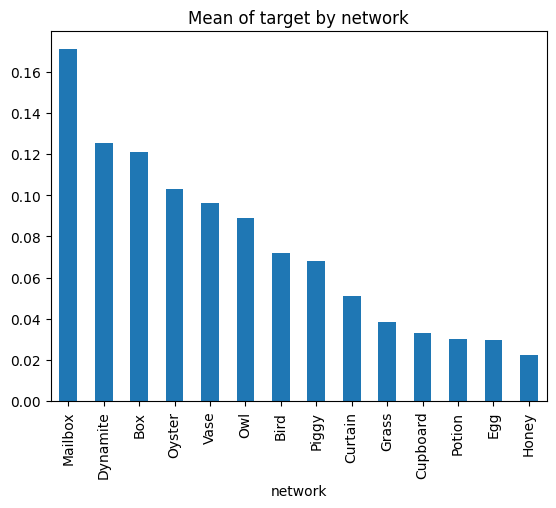

In [8]:
y_train.groupby(df['country'].loc[y_train.index]).mean().sort_values(ascending=False).plot(kind='bar', title = 'Mean of target by country')
plt.show()
y_train.groupby(df['platform'].loc[y_train.index]).mean().sort_values(ascending=False).plot(kind='bar', title = 'Mean of target by platform')
plt.show()
y_train.groupby(df['network'].loc[y_train.index]).mean().sort_values(ascending=False).plot(kind='bar', title = 'Mean of target by network')
plt.show()

### Probabilty Calibration

In [9]:
### merging one hot encoded columns with scaled data
X_train_scaled = pd.concat([X_train[one_hot_encoded_columns],X_train_scaled], axis=1)
X_test_scaled = pd.concat([X_test[one_hot_encoded_columns],X_test_scaled], axis=1)
print(X_train_scaled.shape, X_test_scaled.shape)

(274015, 53) (68504, 53)


In [10]:
"""
data is highly imbalanced so we consider using sample weights during fir and recalibrate the model later,
we will use the inverse of the class frequency as sample weights, It seems a logical strategy but to see if it works,
we will compare the results with and without sample weights with a simple logistic regression model
"""

print(y_train.value_counts(normalize=True))

made_purchase
0    0.92165
1    0.07835
Name: proportion, dtype: float64


Baseline Logistic Regression (No Sample Weights)
ROC AUC: 0.859
Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     63137
           1       0.62      0.11      0.19      5367

    accuracy                           0.93     68504
   macro avg       0.78      0.55      0.58     68504
weighted avg       0.91      0.93      0.90     68504

Coefficients:
Intercept: -2.5018636037210187
event_participate: 0.9549191984698826
country_Amaryllis: 0.9278444597396581
country_Azurelia: -0.30780735731366843
country_Brighthaven: 0.024096569004365475
country_Crystalbrook: -0.13451111348344125
country_Eldoria: 0.7000595337236923
country_Emberlyn: -0.29104571806369184
country_Floravia: 0.3553226029346813
country_Frostford: -1.526925486351569
country_Gleamwood: 0.7362838168041513
country_Glimmerdell: 0.5260258347061565
country_Luminara: -0.5468117807904921
country_Moonvale: -2.073594681464272
country_Rosewyn: -0.06

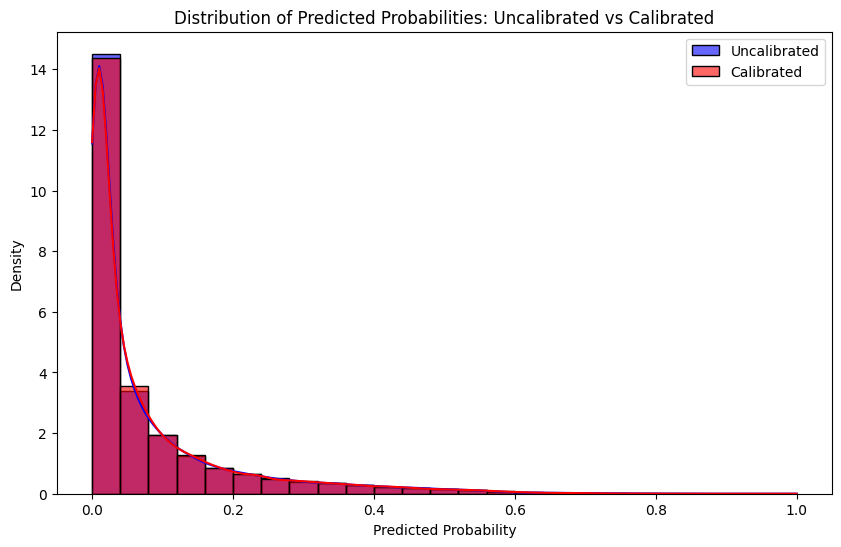

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator  # Requires scikit-learn >= 1.1

# --------------------------
# Assume X_train_scaled, X_test_scaled, y_train, y_test are already defined.
# For example:
# X_train_scaled = pd.DataFrame(...)  
# X_test_scaled = pd.DataFrame(...)  
# y_train = pd.Series(...)  
# y_test = pd.Series(...)
# --------------------------

# ========= Baseline: Logistic Regression without Sample Weights =========

# Initialize and fit the logistic regression model.
logreg_baseline = LogisticRegression(max_iter=1000)
logreg_baseline.fit(X_train_scaled, y_train)

# Predict probabilities on test set.
y_proba_baseline = logreg_baseline.predict_proba(X_test_scaled)[:, 1]

# Evaluate the baseline model.
print("Baseline Logistic Regression (No Sample Weights)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_baseline):.3f}")
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_proba_baseline > 0.5))

# Display coefficients.
print("Coefficients:")
print(f"Intercept: {logreg_baseline.intercept_[0]}")
for feature, beta in zip(X_train_scaled.columns, logreg_baseline.coef_[0]):
    print(f"{feature}: {beta}")

# ========= Logistic Regression with Sample Weights and Calibration =========

# Compute sample weights based on inverse frequency of each class.
# This mapping assigns a higher weight to the minority class.
sample_weights = y_train.map({
    0: 1 / y_train.value_counts(normalize=True)[0],
    1: 1 / y_train.value_counts(normalize=True)[1]
})

# Train logistic regression with sample weights.
logreg_weighted = LogisticRegression(max_iter=1000)
logreg_weighted.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Wrap the trained model in FrozenEstimator to prevent refitting during calibration.
frozen_logreg = FrozenEstimator(logreg_weighted)

# Calibrate the probabilities using CalibratedClassifierCV.
calibrated_clf = CalibratedClassifierCV(estimator=frozen_logreg, cv=5, method="sigmoid", n_jobs=-1, ensemble=False)
calibrated_clf.fit(X_train_scaled, y_train)

# Evaluate the calibrated model.
y_proba_calibrated = calibrated_clf.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression with Inverse-Frequency Sample Weights + Calibration")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_calibrated):.3f}")
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_proba_calibrated > 0.5))

# Display coefficients (from the underlying logistic regression model).
print("Coefficients (from weighted logistic regression):")
print(f"Intercept: {logreg_weighted.intercept_[0]}")
for feature, beta in zip(X_train_scaled.columns, logreg_weighted.coef_[0]):
    print(f"{feature}: {beta}")

# ========= Plotting the Distribution of Predicted Probabilities =========

plt.figure(figsize=(10, 6))

# Plot distribution for the uncalibrated (baseline) model.
sns.histplot(y_proba_baseline, color="blue", kde=True, label="Uncalibrated", stat="density", bins=25, alpha=0.6)

# Plot distribution for the calibrated model.
sns.histplot(y_proba_calibrated, color="red", kde=True, label="Calibrated", stat="density", bins=25, alpha=0.6)

plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities: Uncalibrated vs Calibrated")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator  # Requires scikit-learn >= 1.1

# Hyper params
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10, 20],
}

# sample weights
sample_weights = y_train.map({
    0: 1 / y_train.value_counts(normalize=True)[0],
    1: 1 / y_train.value_counts(normalize=True)[1]
})


### Rf without sample weights
rf_unweighted = RandomForestClassifier(random_state=42)
random_search_unweighted = RandomizedSearchCV(
    estimator=rf_unweighted,
    param_distributions=param_grid,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search_unweighted.fit(X_train_scaled, y_train)

print("Unweighted RandomForest - Best ROC AUC:", random_search_unweighted.best_score_)
print("Best Hyperparameters (Unweighted):", random_search_unweighted.best_params_)

best_rf_unweighted = random_search_unweighted.best_estimator_

### Rf with sample weights
rf_weighted = RandomForestClassifier(random_state=42)
random_search_weighted = RandomizedSearchCV(
    estimator=rf_weighted,
    param_distributions=param_grid,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_weighted.fit(X_train_scaled, y_train, sample_weight=sample_weights)

print("\nWeighted RandomForest - Best ROC AUC:", random_search_weighted.best_score_)
print("Best Hyperparameters (Weighted):", random_search_weighted.best_params_)

best_rf_weighted = random_search_weighted.best_estimator_

# ========= 3. Evaluate Unweighted Model (Uncalibrated and Calibrated) =========

# Uncalibrated predictions
y_proba_unweighted = best_rf_unweighted.predict_proba(X_test_scaled)[:, 1]
print("\nUnweighted RandomForest (Uncalibrated)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_unweighted):.3f}")
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_proba_unweighted > 0.5))

# Calibrate the unweighted model.
frozen_rf_unweighted = FrozenEstimator(best_rf_unweighted)
calibrated_unweighted = CalibratedClassifierCV(
    estimator=frozen_rf_unweighted, cv=5, method="sigmoid", n_jobs=-1, ensemble=False
)
calibrated_unweighted.fit(X_train_scaled, y_train)
y_proba_unweighted_cal = calibrated_unweighted.predict_proba(X_test_scaled)[:, 1]
print("\nUnweighted RandomForest (Calibrated)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_unweighted_cal):.3f}")
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_proba_unweighted_cal > 0.5))


# Uncalibrated predictions for weighted model.
y_proba_weighted = best_rf_weighted.predict_proba(X_test_scaled)[:, 1]
print("\nWeighted RandomForest (Uncalibrated)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_weighted):.3f}")
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_proba_weighted > 0.5))

# weighted model calibration
frozen_rf_weighted = FrozenEstimator(best_rf_weighted)
calibrated_weighted = CalibratedClassifierCV(
    estimator=frozen_rf_weighted, cv=5, method="sigmoid", n_jobs=-1, ensemble=False
)
calibrated_weighted.fit(X_train_scaled, y_train)
y_proba_weighted_cal = calibrated_weighted.predict_proba(X_test_scaled)[:, 1]
print("\nWeighted RandomForest (Calibrated)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_weighted_cal):.3f}")
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_proba_weighted_cal > 0.5))


# Distrbutions of predicted probabilities

plt.figure(figsize=(12, 8))
sns.histplot(y_proba_unweighted, color="blue", kde=True, label="Unweighted Uncalibrated", stat="density", bins=25, alpha=0.6)
sns.histplot(y_proba_unweighted_cal, color="cyan", kde=True, label="Unweighted Calibrated", stat="density", bins=25, alpha=0.6)
sns.histplot(y_proba_weighted, color="red", kde=True, label="Weighted Uncalibrated", stat="density", bins=25, alpha=0.6)
sns.histplot(y_proba_weighted_cal, color="orange", kde=True, label="Weighted Calibrated", stat="density", bins=25, alpha=0.6)

plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities\n(Unweighted vs. Weighted, Uncalibrated vs. Calibrated)")
plt.legend()
plt.show()
